### Variational Inference from scratch in JAX

In [1]:
try:
    import jax
    import jax.numpy as jnp
except ModuleNotFoundError:
    %pip install jax jaxlib
    import jax
    import jax.numpy as jnp

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

try:
    import optax
except ModuleNotFoundError:
    %pip install optax
    import optax

try:
    from rich import print
    from rich.table import Table
except ModuleNotFoundError:
    %pip install rich
    from rich import print
    from rich.table import Table

try:
    from celluloid import Camera
except ModuleNotFoundError:
    %pip install -q celluloid
    from celluloid import Camera


import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import HTML

warnings.filterwarnings("ignore")

In [2]:
dist = tfp.distributions

In [3]:
key = jax.random.PRNGKey(0)

### Unnormalized distribution to be approximated

In [4]:
p = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(probs=jnp.array([0.5, 0.5])),
    components_distribution=dist.Normal(
        loc=jnp.array([-0.2, 1]), scale=jnp.array([0.4, 0.5])  # One for each component.
    ),
)

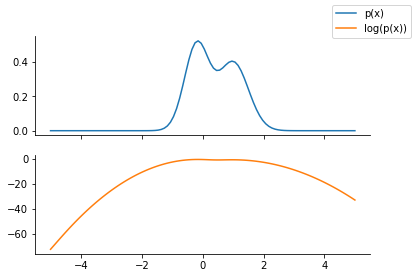

In [5]:
x = jnp.linspace(-5.0, 5.0, 100)
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(x, p.prob(x), label="p(x)", color="C0")
ax[1].plot(x, p.log_prob(x), label="log(p(x))", color="C1")
fig.legend()
sns.despine()

### Computing KL-divergence

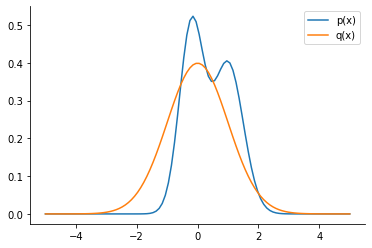

In [6]:
q = dist.Normal(loc=0.0, scale=1.0)
plt.plot(x, p.prob(x), label="p(x)", color="C0")
plt.plot(x, q.prob(x), label="q(x)", color="C1")
plt.legend()
sns.despine()

In [7]:
try:
    dist.kl_divergence(p, q)
except Exception as e:
    print(e)

No KL(distribution_a || distribution_b) registered for distribution_a type MixtureSameFamily 
and distribution_b type Normal

#### Monte Carlo Sampling

In [228]:
def kl_via_sampling(p, q, n_samples=1000):
    key = jax.random.PRNGKey(1)
    # Get samples from q
    sample_set = q.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    # Use the definition of KL-divergence
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [229]:
klv = kl_via_sampling(p, q)
klv

DeviceArray(45.82301, dtype=float32)

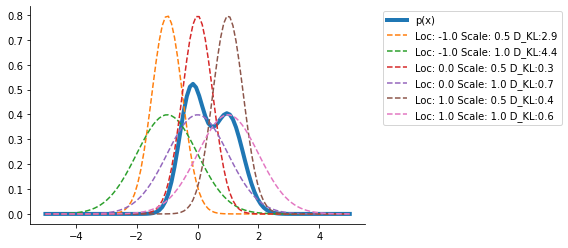

In [230]:
plt.plot(x, p.prob(x), label="p(x)", lw=4)


out = {}
for loc in [-1.0, 0.0, 1.0]:
    out[loc] = {}
    for scale in [0.5, 1.0]:
        q_loc_scale = dist.Normal(loc=loc, scale=scale)
        out[loc][scale] = kl_via_sampling(p, q_loc_scale)
        plt.plot(
            x,
            q_loc_scale.prob(x),
            label=f"Loc: {loc} Scale: {scale} D_KL:{out[loc][scale]:0.1f}",
            ls="--",
        )

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
sns.despine()

Clearly, the <loc = 0., scale = 0.5> seems the closest from the range of distributions we have tried. 

### Reparameterization

We use the following concept: 

1. We parameterize q via its parameters (which we now learn)
2. We generate the samples from a standard normal distribution and then rescale them for q's location and scale
3. Our KL-divergence and hence the loss is a function of the parameters of q and thus we can use autograd functionality

In [231]:
def kl_reparam(p, q_loc, q_scale, n_samples=1000):
    key = jax.random.PRNGKey(1)
    q = dist.Normal(loc=q_loc, scale=q_scale)
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    sample_set = q_loc + q_scale * sample_set
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [232]:
klv_rep = kl_reparam(p, 0.0, 1.0)

In [233]:
klv_rep, klv

(DeviceArray(0.7333999, dtype=float32), DeviceArray(45.82301, dtype=float32))

We can confirm that the KL-divergence we obtain via generating samples directly from q or via generating samples from standard normal and then scaling are the same

### Optimizing the ELBO

I first redefine the function to make use of a dictionary instead of passing them as separate arguments.

In [234]:
softplus = lambda x: jnp.log(1. + jnp.exp(x))

In [235]:
@jax.jit
def kl_reparam(p, params, n_samples=2, key = jax.random.PRNGKey(1)):
    q_loc, q_scale = params["loc"], softplus(params["scale"])
    q = dist.Normal(loc=q_loc, scale=q_scale)
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    sample_set = q_loc + q_scale * sample_set
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [236]:
grad_loss = jax.grad(kl_reparam, argnums=(1))

In [237]:
params = {"loc": jnp.array([1.0]), "scale": jnp.array([1.])}


grad_theta_val = grad_loss(p, params)
grad_theta_val, kl_reparam(p, params)

({'loc': DeviceArray([5.651875], dtype=float32),
  'scale': DeviceArray([8.856307], dtype=float32)},
 DeviceArray(6.945302, dtype=float32))

In [238]:
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

In [239]:
import numpy as np

num_iter = 300
costs = np.empty(num_iter)
key = jax.random.PRNGKey(1)
params_array = []
for i in range(num_iter):
    key, subkey = jax.random.split(key)
    cost_val = kl_reparam(p, params, key = subkey)
    costs[i] = cost_val
    grads = grad_loss(p, params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    params_array.append(params)

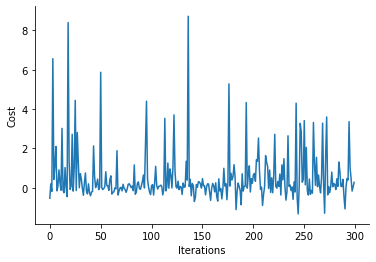

In [240]:
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
sns.despine()

In [241]:
params

{'loc': DeviceArray([-0.2881426], dtype=float32),
 'scale': DeviceArray([0.04360975], dtype=float32)}

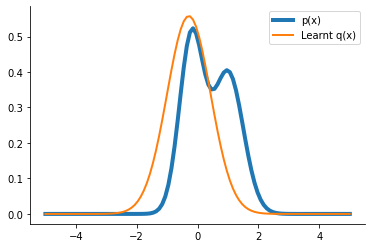

In [242]:
q_learnt = dist.Normal(loc=params["loc"], scale=softplus(params["scale"]))
plt.plot(x, p.prob(x), label="p(x)", lw=4)
plt.plot(x, q_learnt.prob(x), label="Learnt q(x)", lw=2)
plt.legend()
sns.despine()

In [183]:
from celluloid import Camera
from matplotlib.lines import Line2D


fig = plt.figure()
camera = Camera(fig)

labels = ["p(x)", "Learnt q(x)"]
colors = ["C0", "C1"]
handles = []
for c, l in zip(colors, labels):
    handles.append(Line2D([0], [0], color = c, label = l))


for i in range(num_iter):
    q_learnt = dist.Normal(loc=params_array[i]["loc"], scale=params_array[i]["scale"])
    plt.plot(x, p.prob(x),lw=4, color='C0')
    plt.plot(x, q_learnt.prob(x), lw=2, color='C1')
    plt.legend(handles = handles)
    sns.despine()
    camera.snap()
plt.close(fig)
animation = camera.animate()
HTML(animation.to_html5_video())

In [151]:
tfd = tfp.distributions
import optax  # Requires JAX backend.
init_normal, build_normal = tfp.experimental.util.make_trainable_stateless(
  tfd.Normal, name='q_z')

In [184]:
from collections import namedtuple
 
pa = namedtuple('normal_tuple', ['loc', 'scale'])
 
S = pa(1., 0.)
S

normal_tuple(loc=1.0, scale=0.0)

In [189]:
build_normal(S).loc, S.loc

(DeviceArray(1., dtype=float32, weak_type=True), 1.0)

In [191]:
build_normal(S).scale, softplus(S.scale)

(DeviceArray(0.6931473, dtype=float32),
 DeviceArray(0.6931472, dtype=float32, weak_type=True))

In [161]:

optimized_parameters, losses = tfp.vi.fit_surrogate_posterior_stateless(
    p.log_prob,
    build_surrogate_posterior_fn=build_normal,
    initial_parameters=init_normal(seed=(42, 42)),
    optimizer=optax.adam(learning_rate=0.1),
    num_steps=200,
    seed=jax.random.PRNGKey(42))
q_z = build_normal(*optimized_parameters)

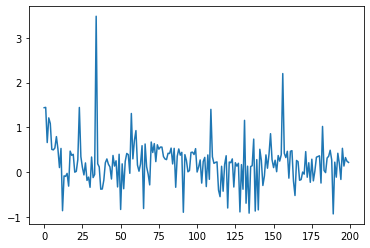

In [162]:
plt.plot(losses)

In [167]:
optimized_parameters.loc, softplus(optimized_parameters.scale)

(DeviceArray(0.7205277, dtype=float32), DeviceArray(0.6584856, dtype=float32))

In [170]:
q_z.loc, q_z.scale

(DeviceArray(0.7205277, dtype=float32), DeviceArray(0.6584857, dtype=float32))

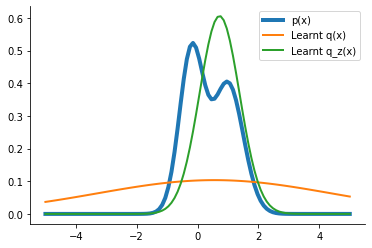

In [166]:
q_learnt = dist.Normal(loc=params["loc"], scale=params["scale"])
plt.plot(x, p.prob(x), label="p(x)", lw=4)
plt.plot(x, q_learnt.prob(x), label="Learnt q(x)", lw=2)
plt.plot(x, q_z.prob(x), label="Learnt q_z(x)", lw=2)


plt.legend()
sns.despine()